# Age, Cholesterol, Blood Pressure, and Chest Pain in Determining Heart Disease

Andy Hong, Celine Li, Jason Shi, Ibrahim Saeed

# Introduction

Heart disease is the one of the leading causes of death for people in Canada, with 1 in 12 Canadian adults living with diagnosed heart disease. There are a number of factors that contribute to heart disease, the main ones being high blood pressure, high cholesterol levels, and age. Symptoms can vary between the type of heart disease and sex, but the most common symptoms include chest pain/tightness, shortness of breath, and feeling light headed and dizzy. Due to the commonality of heart disease, understanding the relationship between different factors can help people maintain a healthy cardiovascular system and decrease their chances of having heart problems.
Using the Heart Disease dataset and the Cleveland database, our goal is to predict if a patient with certain factors will have a higher chance of having heart disease. The variables we are using will be age, cholesterol level, resting blood pressure, and chest pain. Finally, using these variables, we can classify whether or not that patient has heart disease by asking the question: 

Is a patient more prone to heart disease, based on age, cholesterol levels, chest pain, and blood pressure?


# Preliminary Data Analysis

In [2]:
# Load Packages
library(tidyverse)
library(testthat)
library(digest)
library(repr)
library(tidymodels)

options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘testthat’


The following object is masked from ‘package:dplyr’:

    matches


The following object is masked from ‘package:purrr’:

    is_null


The following objects are masked from ‘package:readr’:

    edition_get, local_edition


The following object is masked from ‘package:tidyr’:

    matches


── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0  

Preliminary Exploratory Data Analysis

In the code below, we can prove that the dataset can be read from the web. We will be naming the dataset "heart_data". 


In [3]:
heart_data <- read_csv("data/processed.cleveland.data", col_names = FALSE)

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): X12, X13
dbl (12): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


We notice that there are no column names for the data set thus we will need to add column names based on what each column represents.

In [4]:
names <- c("age","sex","cp","trestbps",
           "chol","fbs","restecg","thalach",
           "exang","oldpeak","slope",
           "ca","thal","num")

colnames(heart_data) <- names
heart_data

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
57,1,4,130,131,0,0,115,1,1.2,2,1.0,7.0,3
57,0,2,130,236,0,2,174,0,0.0,2,1.0,3.0,1
38,1,3,138,175,0,0,173,0,0.0,1,?,3.0,0


Note that at the moment many column names cannot be easily understood at first glance, but for this analysis we are only interested in the variables age, chestpain type, resting blood presssure, cholesterol level, and if a patient has heart diesease or not. Therefore, let's select for the columns we are interested in and tidy it up. 

In [5]:
heart_data_select <- select(heart_data, age, cp, trestbps, chol, num)
slice(heart_data_select,1:5)


age,cp,trestbps,chol,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
63,1,145,233,0
67,4,160,286,2
67,4,120,229,1
37,3,130,250,0
41,2,130,204,0


Using the slice function, we see that the data is tidy as each column is of only 1 variable, each row is one unique obsevation and each cell only contains one value. 

In [6]:
sum(is.na(heart_data_select))

[1] 0

Using the slice function, we see that the data is tidy as each column is of only 1 variable, each row is one unique obsevation and each cell only contains one value. To check if there are any missing values, we can inbed the is.na() function into the sum() function. 

Now, let's serperate our training data from the testing data and summarize the training idea to get a good idea of what we are working with. To make sure the results are reproducible, a seed wll be set as well. 

In [7]:
#splitting dataframe into training, testing datasets
set.seed(1)
heart_clean <- mutate(heart_data, 
                          age = as.numeric(age), cp = as.numeric(cp), 
                          chol = as.numeric(chol), trestbps = as.numeric(trestbps)) %>%
                          mutate(diag = ifelse(is.na(num), NA, (num > 0))) 

heart_split <- initial_split(heart_clean, prop = 3/4, strata = num)

heart_training <- training(heart_split)
heart_testing <- testing(heart_split)


We then summarize this data into values we want, and put them onto a graph

In [8]:
#summarizing training data into a table and getting mean, min, max
heart_summarized <- heart_training %>%
group_by(diag) %>%
summarize(min_age = min(age), max_age = max(age), mean_age = mean(age),
          min_cp  = min(cp), max_cp = max(cp), mean_cp = mean(cp),
          min_chol = min(chol), max_chol = max(chol), mean_chol = mean(chol),
          min_trestbps = min(trestbps), max_trestbps = max(trestbps), 
                             mean_trestbps = mean(trestbps), no_patients = n())
heart_summarized
          
          


diag,min_age,max_age,mean_age,min_cp,max_cp,mean_cp,min_chol,max_chol,mean_chol,min_trestbps,max_trestbps,mean_trestbps,no_patients
<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
FALSE,29,76,52.68548,1,4,2.774194,126,564,244.2903,94,180,129.7339,124
TRUE,35,77,56.48039,1,4,3.578431,131,409,249.3627,100,192,133.9020,102


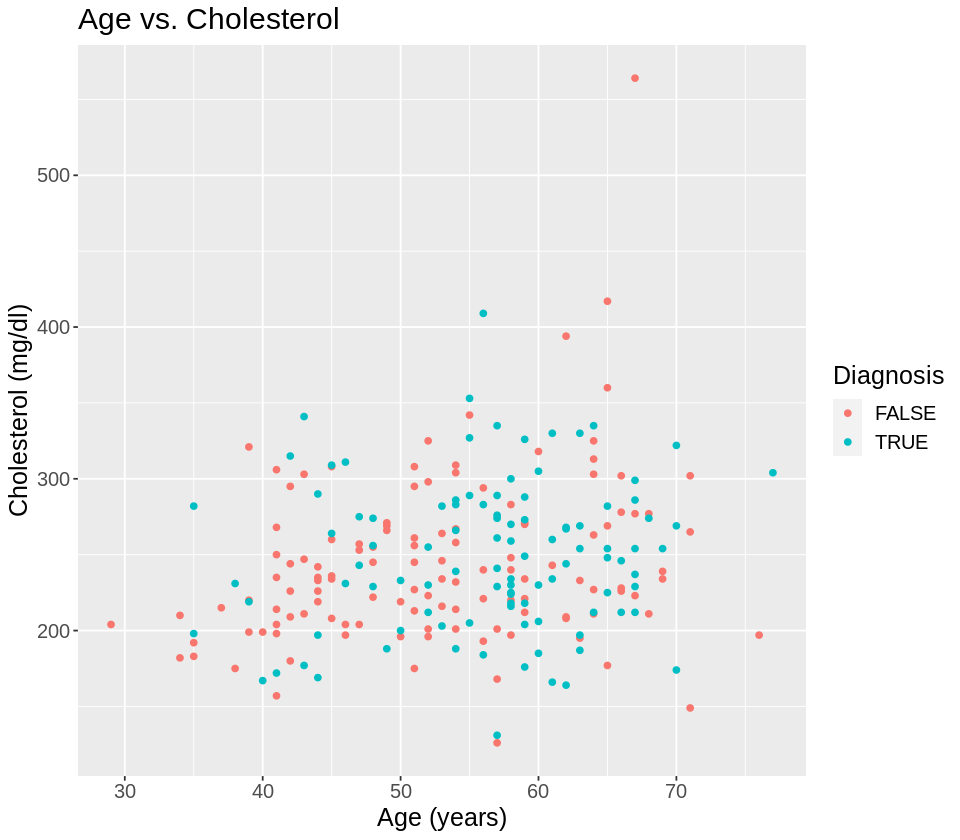

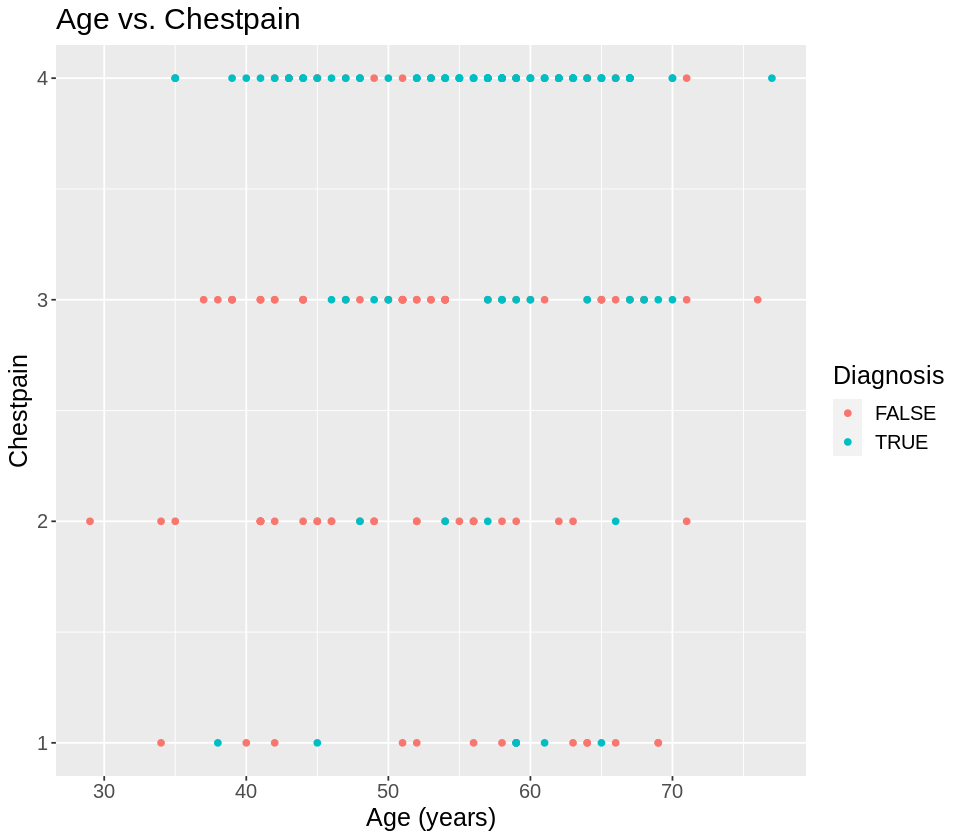

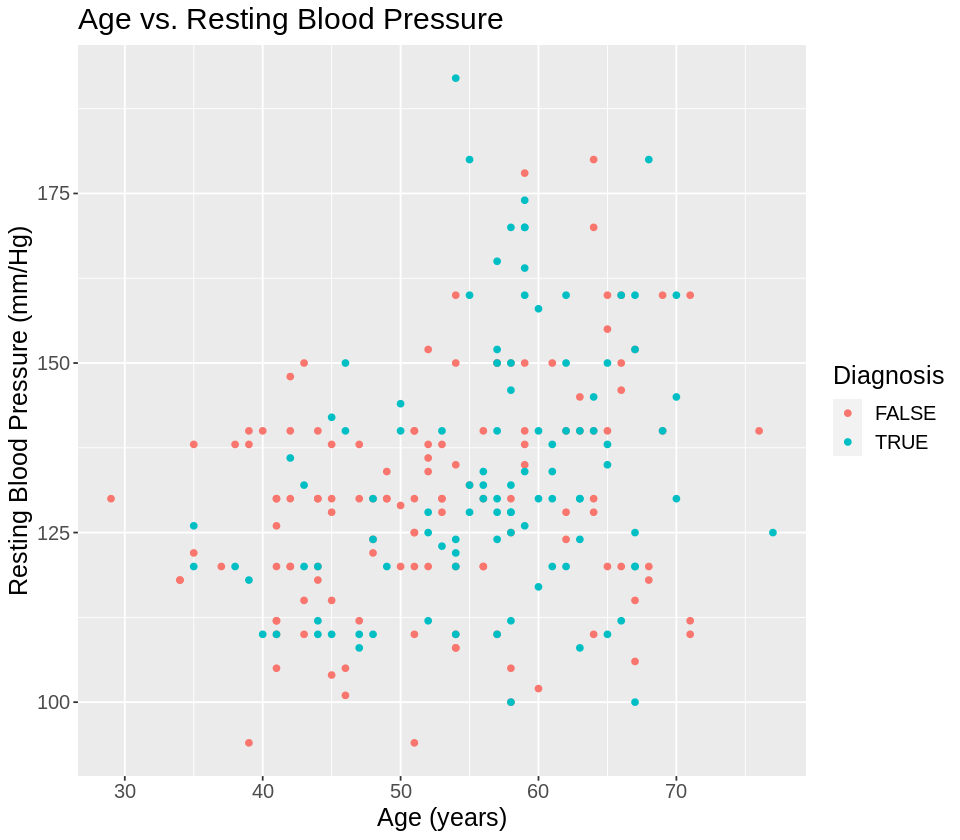

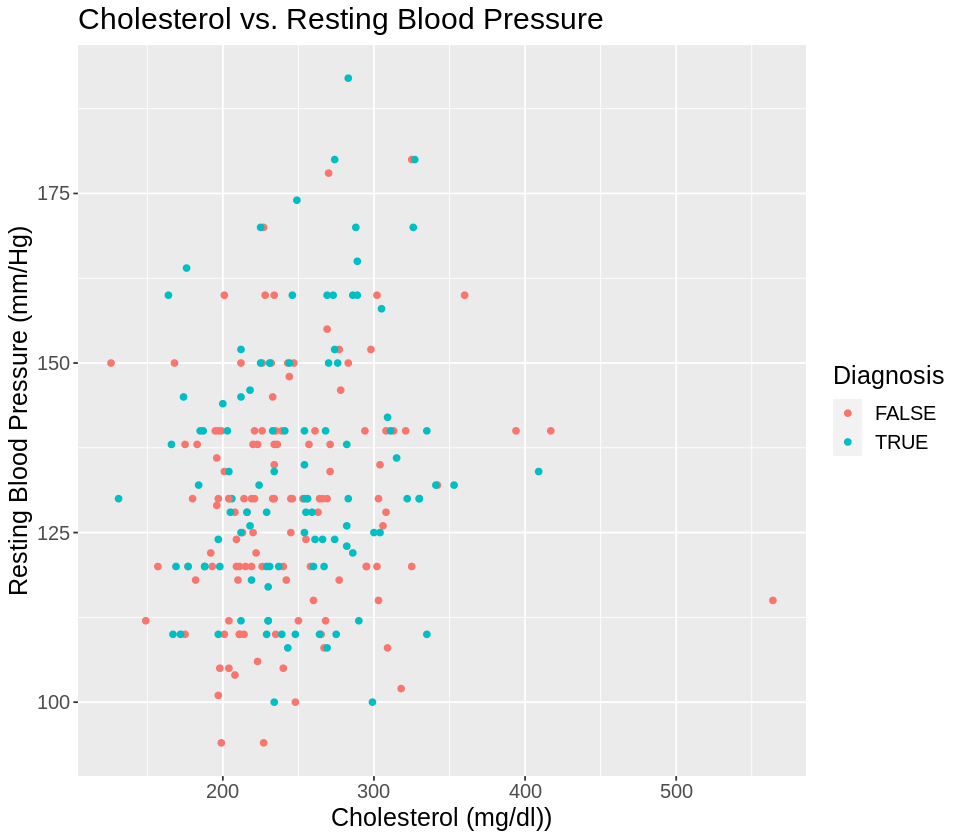

In [14]:
#Plotting this data to find correlation of diagnosis
options(repr.plot.width = 8, repr.plot.height = 7)

graph <- ggplot(heart_training, aes(x = age, y = chol, color = diag)) +
                 geom_point() +
                 labs(x = "Age (years)", y = "Cholesterol (mg/dl)", color = "Diagnosis", title = "Age vs. Cholesterol") +
                 theme(text = element_text(size = 15))

graph2 <- ggplot(heart_training, aes(x = age, y = cp, color = diag)) +
                 geom_point() +
                 labs(x = "Age (years)", y = "Chestpain", color = "Diagnosis", title = "Age vs. Chestpain") +
                 theme(text = element_text(size = 15))

graph3 <- ggplot(heart_training, aes(x = age, y = trestbps, color = diag)) +
                 geom_point() +
                 labs(x = "Age (years)", y = "Resting Blood Pressure (mm/Hg)", color = "Diagnosis", title = "Age vs. Resting Blood Pressure") +
                 theme(text = element_text(size = 15))

graph4 <- ggplot(heart_training, aes(x = chol, y = trestbps, color = diag)) +
                 geom_point() +
                 labs(x = "Cholesterol (mg/dl))", y = "Resting Blood Pressure (mm/Hg)", color = "Diagnosis", title = "Cholesterol vs. Resting Blood Pressure") +
                 theme(text = element_text(size = 15))

graph
graph2
graph3
graph4

# Methods
For our data analysis, the predictor columns we will be using from this dataset are age, cholesterol level, resting blood pressure, chest pain, and the class column will be the disease column which tells us whether or not the patient has heart disease present. We picked these predictor columns because our research entails that these factors are most relevant to whether someone has heart disease based on the attributes given to us in this dataset (Davar et al., 2017). To conduct this analysis, we will be using the K-nearest neighbors classifier. We will be using R to split our data set into a training and testing set. In the training set we will execute cross-validation on our training set to pick the best-fit K value for our predictor. To keep up with good data analysis practices, a seed value will be set so our analysis can be reproduced. We split our data into testing and training sets using initial_split. Using the training set, we graph plots using our variables, seperating them by Diag or our diagnosis variable to identify where in the graph we see more heart disease vs no heart disease. As we see in the graphs that there is clear sections with more FALSE diagnosis (no heart disease) and where there are more TRUE diagnosis (heart disease), it means that these variables are useful for prediction and we will use them as our predictors.

# Expected Outcomes and Significance
Considering our variables, we expect to find those who are older, have high cholesterol levels, high blood pressure, and experience atypical or typical chest pain to have the highest chance of having heart disease. With heart disease being the second leading cause of death after cancer, it is essential that we know the factors that impact our heart’s health so we can prevent complications in the future. Using what we find in our model, we can help identify who has heart disease and treat them faster. This could lead to future questions such as how can we better prevent heart disease early in age? What factors result in heart disease for young people? Lastly, what is the greatest cause for heart disease?